The purpose of this notebook is to develop architecture and utilities for fit neural network on B → J reconstruction problem.

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
from IPython.display import display, clear_output

In [4]:
import sys
sys.path.append('../../..')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [6]:
from magrec.misc.load import load_matlab_data

Loaded data of shape (4, 125, 55), padded up to torch.Size([4, 128, 64]), with spacing dx = 0.020 μm, dy = 0.029 μm


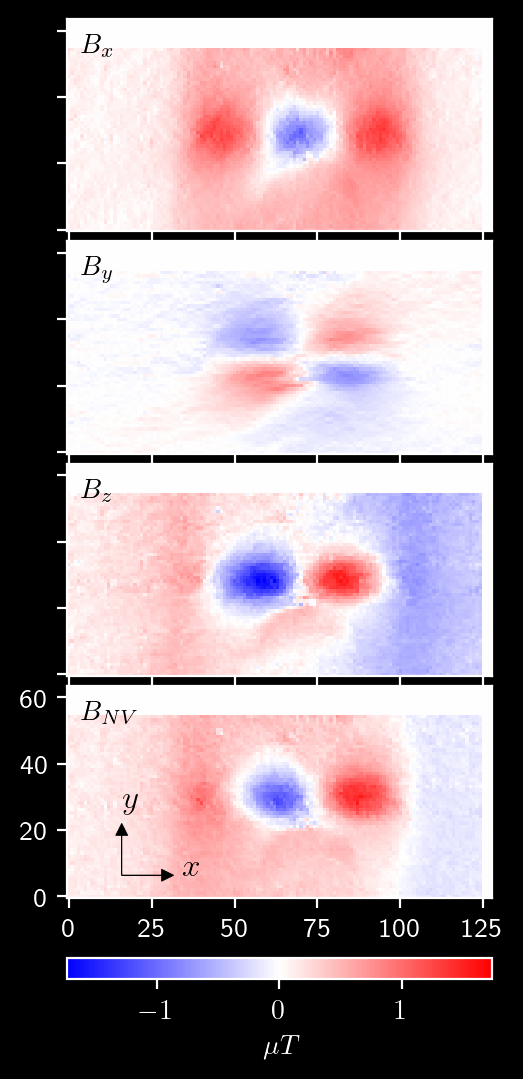

In [185]:
mat = load_matlab_data(__datapath__ / "ExperimentalData" / "Harvard" / "XY_Bnv_Bxyz_Jxy_SChenJJ_data2.mat")

Bx = mat['BX_map'].T
By = mat['BY_map'].T
Bz = mat['BZ_map'].T
Bnv = mat['Bnv_map'].T

B = np.stack((Bx, By, Bz, Bnv), axis=0)
original_shape = B.shape

# make roi slice obejct out of the original shape, assuming the data starts at (0, 0)
roi_original = (slice(None), slice(original_shape[-2]), slice(original_shape[-1]))

B = B * 1e6 # convert to μT

B = torch.tensor(B, dtype=torch.float32)

# pad until each dimension is a multiple of 32
# calculate roi to mask out the padding
roi = (slice(None), slice(B.shape[-2]), slice(B.shape[-1]))

B = F.pad(B, (0, 32 - B.shape[-1] % 32, 0, 32 - B.shape[-2] % 32), mode='constant', value=0)

# convert roi to mask
mask = torch.zeros_like(B)
mask[roi] = 1

plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr", units="T", alignment="vertical",)

# find mean spacing between points, assuming uniform (more or less) grid
dx = np.diff(mat['rx_inv']).mean()
dy = np.diff(mat['ry_inv']).mean()

print(f'Loaded data of shape {original_shape}, padded up to {B.shape}, with spacing dx = {dx:.3f} μm, dy = {dy:.3f} μm')

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = 54.7            # degrees
phi = 30              # degrees

# Projection object to compute the projection of the vector onto the defined axis
proj = AxisProjectionPropagator(theta=theta, phi=phi)

# Show how the data looks like
plot_n_components(B, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], cmap="bwr", units=r"$\mu T$", alignment="vertical",)

In [186]:
roi

(slice(None, None, None), slice(None, 125, None), slice(None, 55, None))

In [187]:
original_shape

(4, 125, 55)

# Neural net architecture

In [227]:
class CNN(nn.Module):
    # class to create a convolutionnal neural network for magnetisation reconstruction

    def __init__(self, Size=2, ImageSize=256, kernel = 5, stride = 2, padding = 2, channels_in = 1, channels_out=1):
        super().__init__()

        M = Size

        if ImageSize == 512:
            ConvolutionSize = 32
        elif ImageSize == 256:
            ConvolutionSize = 16
        else: # size is 128
            ConvolutionSize = 8
        # first index is the number of channels
        self.convi = nn.Conv2d(channels_in, 8*M, kernel, 1, padding)
        self.conv_r0 = nn.Conv2d(1, 8*M, kernel, 1, padding)
        self.conv1 = nn.Conv2d(8*M, 8*M, kernel, stride, padding)
        self.bn1  = nn.BatchNorm2d(8*M)
        self.conv2 = nn.Conv2d(8*M, 16*M, kernel, stride, padding)
        self.bn2  = nn.BatchNorm2d(16*M)
        self.conv3 = nn.Conv2d(16*M, 32*M, kernel, stride, padding)
        self.bn3  = nn.BatchNorm2d(32*M)
        self.conv4 = nn.Conv2d(32*M, 64*M, kernel, stride, padding)
        self.bn4  = nn.BatchNorm2d(64*M)

        self.conv5 = nn.Conv2d(64*M, 128*M, 5, 1, 2)
        self.bn5  = nn.BatchNorm2d(128*M)

        # add extra BatchNorm2d layers, to avoid reusing them from the encoder part above
        self.trans1 = nn.ConvTranspose2d(128 * M, 64 * M, kernel, stride, padding, 1)
        self.bn4t = nn.BatchNorm2d(64 * M)
        self.trans2 = nn.ConvTranspose2d(64 * M + 32 * M, 32 * M, kernel, stride, padding, 1)
        self.bn3t = nn.BatchNorm2d(32 * M)
        self.trans3 = nn.ConvTranspose2d(32 * M + 16 * M, 16 * M, kernel, stride, padding, 1)
        self.bn2t = nn.BatchNorm2d(16 * M)
        self.trans4 = nn.ConvTranspose2d(16 * M + 8 * M, 8 * M, kernel, stride, padding, 1)
        self.bn1t = nn.BatchNorm2d(8 * M)
        self.conv6 = nn.Conv2d(8*M, channels_out, kernel, 1, padding)
        self.conv7 = nn.Conv2d(channels_out, channels_out, kernel, 1, padding)

        self.fc11 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc12 = nn.Linear(120, 84)
        self.fc13 = nn.Linear(84, 1)

        self.fc21 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc22 = nn.Linear(120, 84)
        self.fc23 = nn.Linear(84, 1)

        self.fc31 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc32 = nn.Linear(120, 84)
        self.fc33 = nn.Linear(84, 1)

        self.fc41 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc42 = nn.Linear(120, 84)
        self.fc43 = nn.Linear(84, 1)

        self.fc51 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.fc52 = nn.Linear(120, 84)
        self.fc53 = nn.Linear(84, 1)

        self.transfc1 = nn.Linear(64*M * ConvolutionSize*ConvolutionSize, 120)
        self.transfc2 = nn.Linear(120, 256)
        self.transfc3 = nn.Linear(256, 65536)

    def forward(self,input,
                roi,
                Nv_theta=False,
                Nv_phi=False,
                Nv_Height=False,
                M_angle=False,
                PositiveCurrentOnly = False,):

        conv0 = self.convi(input)
        roi0 = self.conv_r0(roi)
        mask = roi * conv0
        conv0 = F.leaky_relu(mask, 0.2)
        conv1 = F.leaky_relu(self.bn1(self.conv1(conv0)), 0.2)
        conv2 = F.leaky_relu(self.bn2(self.conv2(conv1)), 0.2)
        conv3 = F.leaky_relu(self.bn3(self.conv3(conv2)), 0.2)
        conv4 = F.leaky_relu(self.bn4(self.conv4(conv3)), 0.2)

        conv5 = F.leaky_relu(self.conv5(conv4), 0.2)

        trans1 = F.leaky_relu(self.bn4t(self.trans1(conv5)), 0.2)
        trans2 = F.leaky_relu(self.bn3t(self.trans2(torch.cat([conv3,trans1], dim=1))), 0.2)
        trans3 = F.leaky_relu(self.bn2t(self.trans3(torch.cat([conv2,trans2], dim=1))), 0.2)
        trans4 = F.leaky_relu(self.bn1t(self.trans4(torch.cat([conv1,trans3], dim=1))), 0.2)

        conv6 = self.conv6(trans4)
        conv7 = self.conv7(conv6)
        
        if PositiveCurrentOnly is True:
            conv8 = F.relu(conv7)
        else:
            conv8 = (conv7)
        
        # CurrentTheta = torch.flatten(conv4, 1)
        # CurrentTheta = F.leaky_relu(self.fc11(CurrentTheta), 0.)
        # CurrentTheta = F.leaky_relu(self.fc12(CurrentTheta), 0.)
        # CurrentTheta = (self.fc13(CurrentTheta))

        # CurrentPhi = torch.flatten(conv4, 1)
        # CurrentPhi = F.leaky_relu(self.fc21(CurrentPhi), 0.)
        # CurrentPhi = F.leaky_relu(self.fc22(CurrentPhi), 0.)
        # CurrentPhi = (self.fc23(CurrentPhi))

        # NVTheta = torch.flatten(conv4, 1)
        # NVTheta = F.leaky_relu(self.fc31(NVTheta))
        # NVTheta = F.leaky_relu(self.fc32(NVTheta))
        # NVTheta = self.fc33(NVTheta).abs()

        # NVPhi = torch.flatten(conv4, 1)
        # NVPhi = F.leaky_relu(self.fc41(NVPhi))
        # NVPhi = F.leaky_relu(self.fc42(NVPhi))
        # NVPhi = self.fc43(NVPhi)

        # # MInt as in M intensity (?) a scalar for each sample — MF.
        # JInt = torch.flatten(conv4, 1)
        # JInt = F.leaky_relu(self.fc51(JInt))
        # JInt = F.leaky_relu(self.fc52(JInt))
        # JInt = self.fc53(JInt)
        # JInt = torch.abs(JInt) 
        
        conv9 = conv8

        return conv9
        return JInt, conv9, CurrentTheta, CurrentPhi, NVTheta, NVPhi

In [229]:
def train_net(net: torch.nn.Module, B, n_iter=1000, plot_interval=100, lr=1.):
    """Run the training loop.
    
    Parameters
    ----------
    net : torch.nn.Module
        The network to train

    B : np.ndarray or torch.tensor
        The magnetic field on which to fit reconstruction

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100

    lr : float, optional
        Learning rate, by default 1.
    
    Returns
    -------
    torch.nn.Module
        The trained network
    torch.tensor
        The reconstructed current density
    """ 
    # Define the loss function and the optimizer
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer(net.parameters(), lr=lr)

    W, H = B.shape[-2:]

    pad_repl = torch.nn.ReplicationPad2d((H, H, W, W))

    # calculate what the next power of two is
    expanded_shape = (2, 512, 512)

    pad_zero = torch.nn.ZeroPad2d((0, expanded_shape[-1] - 3*H, 0, expanded_shape[-2] - 3*W))

    # create roi with slices to extract the original image
    roi = (..., slice(W, 2*W), slice(H, 2*H))

    propagator = CurrentPropagator2d(source_shape=expanded_shape[-2:],
                                    dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)

    def compute_B_with_repl(J: torch.tensor):
        """Compute the magnetic field from the current density.

        Returns B in the shape of the original data that is fed into the network. 
        
        - Takes J, extracts the original image size from it, expecting the original image to start at (0, 0). 
        - Pads J with replication on all sides by same width and height as the original image.
        - Pads J with zeros until expanded_shape is reached.
        - Propagates the current density to B.
        - Projects B to B_NV.
        - Stacks B and B_NV to B.
        - Important: extracts from the resultant size of B as that of the input image.
        - Important: mask the boundaries of B with zeros.

        """
        # Extract the original image size from J
        input_shape = J.shape
        J = J[..., :original_shape[-2], :original_shape[-1]]
        # Pad J with replication on all sides by same width and height as the original image
        J = F.pad(J, (0, original_shape[-1] - J.shape[-1], 0, original_shape[-2] - J.shape[-2]), mode='replicate')
        # Pad J with zeros until expanded_shape is reached
        J = F.pad(J, (0, expanded_shape[-1] - J.shape[-1], 0, expanded_shape[-2] - J.shape[-2]), mode='constant', value=0)
        # Propagate the current density to B
        B = propagator(J)
        B_NV = proj.project(B)
        # That's a more general stacking to allow for batch dimension
        B = torch.stack([B[..., -3, :, :], 
                        B[..., -2, :, :], 
                        B[..., -1, :, :], 
                        B_NV[..., :, :]], 
                        dim=-3)

        # Extract from the resultant size of B as that of the input image
        B = B[..., :input_shape[-2], :input_shape[-1]]
        B[mask[None, ...] == 0] = 0
        return B


    # Initialize a list to track loss and update it on each iteration
    track_loss = []

    # Prepare a figure to plot the loss
    fig_loss = plt.figure('Loss')
    fig_loss.suptitle('Loss as a function of iteration')
    fig_loss.supxlabel('Iteration')
    fig_loss.supylabel('Loss')
    
    # Make an axis to plot the loss
    ax_loss = fig_loss.add_subplot(111)

    def show_progress(B_pred, J_pred):
        print(f"Loss at iteration {i}: {loss.item()}")
        fig1 = plot_n_components(J_pred.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
        fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr", units=r'$\mu T$')

        # Plot the loss as a function of iteration
        ax_loss.clear()
        ax_loss.plot(track_loss)
        
        # Make y axis log scale
        ax_loss.set_yscale('log')

        # Display the output in the notebook and clear the output
        display(fig1)
        display(fig2)
        display(fig_loss)
        clear_output(wait=True)
        return fig1, fig2, fig_loss


    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        J_pred = net(B, roi=mask[None, [3], ...])
        # print('After net', J_pred.shape)

        # Compute the predicted B that corresponds to the output current
        B_pred = compute_B_with_repl(J_pred)

        # Extract the B_NV component
        B_pred_NV = B_pred[:, 3, ...]

        # Add a dimension that corresponds to the component
        B_pred_NV = B_pred_NV[:, None, ...]
        
        # Compute the loss
        loss = loss_fn(B, B_pred_NV)
        # Add the loss to the list
        track_loss.append(loss.item())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            fig1, fig2, fig3 = show_progress(B_pred, J_pred)

    print(J_pred.shape)

    display(fig1, fig2, fig3)
    return net

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 6 but got size 7 for tensor number 1 in the list.

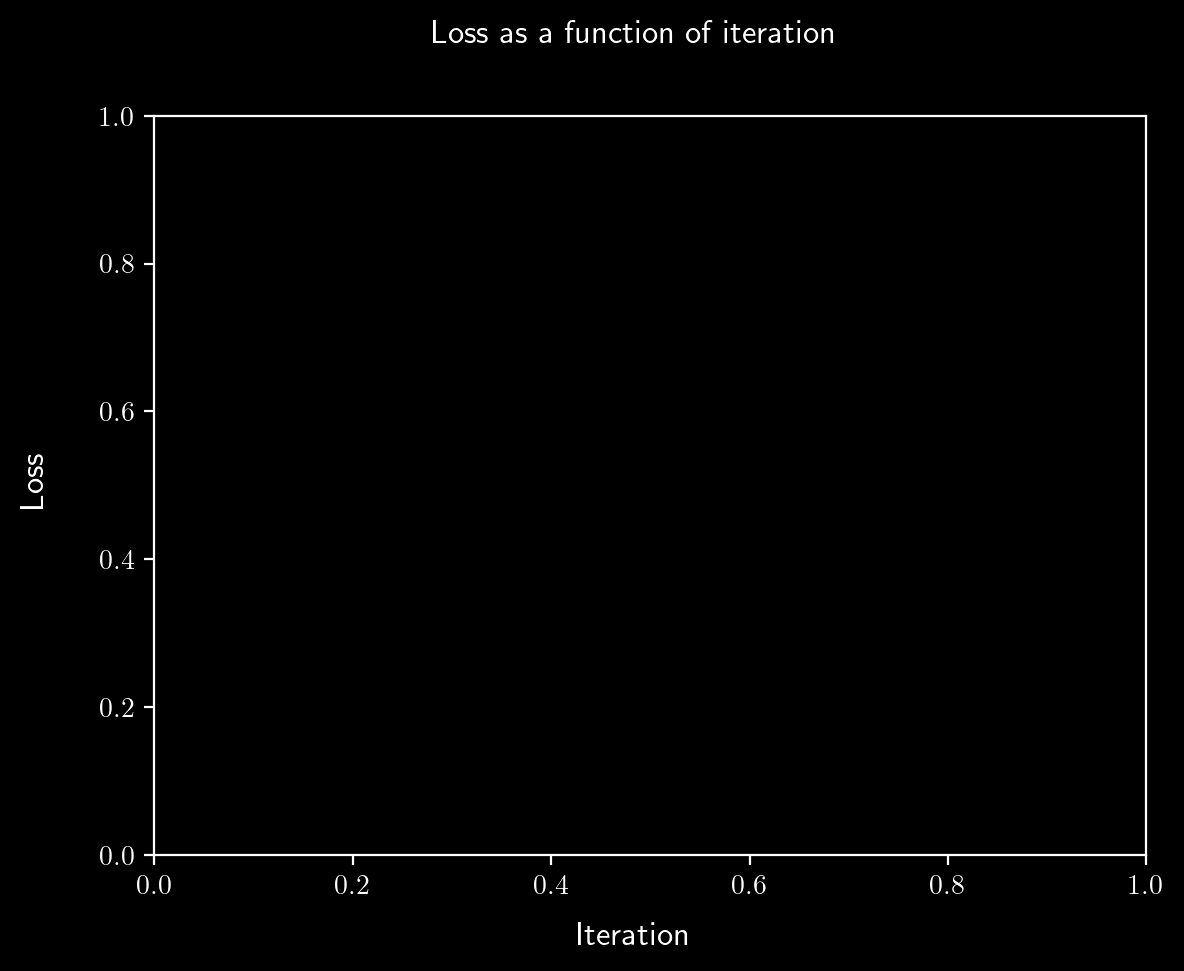

In [242]:
net = CNN(stride=(5, 2), padding=(6, 5), kernel=(13, 11), channels_in=1, channels_out=2)
input = B[None, [3], ...]
train_net(net, B[None, [3], ...], n_iter=1000, plot_interval=100, lr=0.001)

In [121]:
mask.shape

torch.Size([4, 128, 64])

In [131]:
B.shape

(slice(None, None, None), slice(None, 125, None), slice(None, 55, None))

In [150]:
B.shape

torch.Size([4, 128, 64])